In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from pandas import DataFrame
from tqdm import tqdm


In [14]:
# todo
# add boundary conditions mask
# implement temperature

class FluidSimulation:
    def __init__(self, length_x=1, length_y=1, kinematic_viscosity=0.1, denisty=1):
        self.domain_size_x = length_x
        self.domain_size_y = length_y
        self.nu = kinematic_viscosity
        self.rho = denisty

        points_per_unit_length = 41

        self.n_points_x = int(length_x * points_per_unit_length)
        self.n_points_y = int(length_y * points_per_unit_length)

        self.dx = length_x / (self.n_points_x - 1)
        self.dy = length_y / (self.n_points_y - 1)

        self.n_pressure_iterations = 50  # iterations for pressure correction
        self.stability_factor = 0.5  # for stability condition ( < 1)
        self.dt = self.stability_factor * (self.dx*self.dy) / (2 * self.nu)

        self.obstacle_mask = np.ones(
            (self.n_points_y, self.n_points_x))  # 1 - fluid, 0 - obstacle

        #! debug only
        print("points_per_unit_length", points_per_unit_length)
        print("n_points_x", self.n_points_x)
        print("n_points_y", self.n_points_y)
        print('length_x', length_x)
        print('length_y', length_y)
        print('dt', self.dt)

    def init_obstacle_mask(self):
        ''' Initialize obstacle mask by picture '''
        #! hardcode
        # self.obstacle_mask[0:int(self.n_points_y*1/4), 1:-1] = 0.0
        # self.obstacle_mask[int(self.n_points_y*3/4):, 1:-1] = 0.0
        # self.obstacle_mask[:-20,5:-10] = 0

        # Circular initial condition
        x_center = (self.n_points_x / 2) * self.dx
        y_center = (self.n_points_y / 2) * self.dy
        radius = ((self.n_points_x / 4) * self.dx)**2 + \
            ((self.n_points_y/4)*self.dy)**2
        radius = radius**0.5

        for i in range(self.n_points_y):
            for j in range(self.n_points_x):
                x = i * self.dx
                y = j * self.dy
                if (x - x_center)**2 + (y - y_center)**2 <= radius**2:
                    # np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
                    self.obstacle_mask[i, j] = 0
                    # -np.cos(2 * np.pi * x) * np.sin(2 * np.pi * y)
                    self.obstacle_mask[i, j] = 0

    def central_difference_x(self, field):
        ''' Calculate central difference in x direction '''
        diff = np.zeros_like(field)
        diff[1:-1, 1:-1] = (field[1:-1, 2:]-field[1:-1, 0:-2]) / (2 * self.dx)
        return diff

    def central_difference_y(self, field):
        ''' Calculate central difference in y direction '''
        diff = np.zeros_like(field)
        diff[1:-1, 1:-1] = (field[2:, 1:-1]-field[0:-2, 1:-1]) / (2 * self.dy)
        return diff

    def laplace(self, field):
        ''' Calculate laplace operator '''
        laplace = np.zeros_like(field)
        laplace[1:-1, 1:-1] = (field[1:-1, 2:] - 2 * field[1:-1, 1:-1]+field[1:-1, 0:-2]) / (self.dx**2) + \
            (field[2:, 1:-1] - 2 * field[1:-1, 1:-1] +
             field[0:-2, 1:-1]) / (self.dy**2)
        return laplace

    def is_stable(self):
        ''' Check stability condition  CFL'''
        return self.dt <= self.stability_factor * (self.dx*self.dy) / (2 * self.nu)

    def draw_plot(self, u, v, p,):
        x = np.linspace(0, self.domain_size_x, self.n_points_x)
        y = np.linspace(0, self.domain_size_y, self.n_points_y)
        X, Y = np.meshgrid(x, y)

        plt.style.use('dark_background')

        # Velocity boundary conditions
        u_boundary = np.ones_like(u)
        v_boundary = np.ones_like(v)
        self.apply_velocity_boundary_conditions(u_boundary, v_boundary)
        velocity_boundary = u_boundary + v_boundary

        fig_velocity_boundary, ax_velocity_boundary = plt.subplots(dpi=100)
        ax_velocity_boundary.set_title(
            'Velocity boundary conditions / obstacle mask')
        ax_velocity_boundary.set_xlabel('$x$')
        ax_velocity_boundary.set_ylabel('$y$')
        ax_velocity_boundary.imshow(velocity_boundary,
                                    cmap=cm.gray,
                                    origin='lower',
                                    extent=[0, self.domain_size_x, 0, self.domain_size_y], interpolation='none')

        # Velocity  and pressure initial conditions
        u_initial = np.ones_like(u)
        v_initial = np.ones_like(v)
        p_initial = np.ones_like(p)
        self.apply_velocity_initial_conditions(u_initial, v_initial)
        self.apply_pressure_initial_conditions(p_initial)
        self.apply_velocity_boundary_conditions(u_initial, v_initial)
        self.apply_pressure_boundary_conditions(p_initial)

        def streamplot_with_bacground(u_component, v_component, background):
            pass

        fig_initial, ax_initial = plt.subplots(dpi=100)
        ax_initial.set_title('Velocity and pressure initial conditions')
        ax_initial.set_xlabel('$x$')
        ax_initial.set_ylabel('$y$')
        ax_initial.streamplot(X, Y, u_initial, v_initial,
                              color="black", density=1, linewidth=1)
        pressure_contour = ax_initial.contourf(
            X, Y, p_initial, cmap=cm.viridis)
        fig_initial.colorbar(pressure_contour, ax=ax_initial)

        # Velocity  and pressure final conditions
        fig_final, ax_final = plt.subplots(dpi=100)
        ax_final.set_title('Velocity and pressure final conditions')
        ax_final.set_xlabel('$x$')
        ax_final.set_ylabel('$y$')
        ax_final.streamplot(X, Y, u, v,color="black", density=1, linewidth=1)
        pressure_contour = ax_final.contourf(X, Y, p, cmap=cm.viridis)
        #ax_final.quiver(X, Y, u, v, color="black", linewidth=1)  # todo костыль
        fig_final.colorbar(pressure_contour, ax=ax_final)
        ax_final.set_xlim(0, self.domain_size_x)
        ax_final.set_ylim(0, self.domain_size_y)

    def apply_velocity_initial_conditions(self, u, v):
        ''' Apply initial conditions for velocity '''
        u[:, :] = 0.0
        v[:, :] = 0.0
        #! hardcode
        u[1:-1, 1:5] = 1.0
        u[1:-1, int(self.n_points_x*1/4):int(self.n_points_x*3/4)] = 1  # todo костыль для тестов

    def apply_pressure_initial_conditions(self, p):
        ''' Apply initial conditions for pressure '''
        p[:, :] = 0.0

    def apply_velocity_boundary_conditions(self, u, v):
        ''' Apply boundary conditions for velocity '''
        # set velocity on obstacle to zero
        u[:, :] *= self.obstacle_mask[:, :]
        v[:, :] *= self.obstacle_mask[:, :]

        # set velocity on boundary to zero
        u[0, :]  = 0.0
        u[:, 0]  = 0.0
        u[:, -1] = 0.0
        u[-1, :] = 0.0
        v[0, :]  = 0.0
        v[:, 0]  = 0.0
        v[:, -1] = 0.0
        v[-1, :] = 0.0

    def apply_pressure_boundary_conditions(self, p):
        ''' Apply boundary conditions for pressure '''
        #? set pressure on obstacle to zero
        p[:, :] *= self.obstacle_mask[:, :]
        # todo
        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:,  0] = p[:,  1]
        p[-1, :] = 0.0

    def calculate_pressure_field(self, p, b):
        ''' Solve poission equation '''
        # copied from https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/13_Step_10.ipynb
        p = np.zeros((self.n_points_y, self.n_points_x))  # initial guess
        for _ in range(self.n_pressure_iterations):
            pd = p.copy()
            p[1:-1, 1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * self.dy**2 +
                              (pd[2:, 1:-1] + pd[:-2, 1:-1]) * self.dx**2 -
                              b[1:-1, 1:-1] * self.dx**2 * self.dy**2) /
                             (2 * (self.dx**2 + self.dy**2)))
            self.apply_pressure_boundary_conditions(p)
        return p

    def simulate(self, n_iterations):

        # check stability condition
        if not self.is_stable():
            raise Exception("Stability condition is not satisfied")
        else:
            print("Stability condition is satisfied")

        grid_shape = (self.n_points_y, self.n_points_x)

        # initialisation
        u = np.zeros(grid_shape)  # u component of velocity
        v = np.zeros(grid_shape)  # v component of velocity
        p = np.zeros(grid_shape)  # pressure field
        t = np.zeros(grid_shape)  # todo temperature field

        # apply initial conditions for velocity, pressure and temperature
        self.apply_velocity_initial_conditions(u, v)
        self.apply_pressure_initial_conditions(p)
        # todo self.apply_temperature_initial_conditions(t)

        # apply boundary conditions
        self.apply_velocity_boundary_conditions(u, v)
        self.apply_pressure_boundary_conditions(p)

        # main simulation loop
        for iteration in tqdm(range(n_iterations)):
            du_dx = self.central_difference_x(u)
            du_dy = self.central_difference_y(u)
            dv_dx = self.central_difference_x(v)
            dv_dy = self.central_difference_y(v)
            laplace_u = self.laplace(u)
            laplace_v = self.laplace(v)

            # Advection term : (u ⋅ ∇) u
            u_advection = u*du_dx + v*du_dy  # advection term for u
            v_advection = u*dv_dx + v*dv_dy  # todo

            # Diffusion term : ν ∇²u
            u_diffusion = self.nu * laplace_u  # todo
            v_diffusion = self.nu * laplace_v   # todo

            # perform a tentative velocity step by solving momentum equation with no pressure term
            u = u + self.dt * (-u_advection + u_diffusion)
            v = v + self.dt * (-v_advection + v_diffusion)

            # apply boundary conditions for tentative velocity
            self.apply_velocity_boundary_conditions(u, v)

            du_tent_dx = self.central_difference_x(u)
            dv_tent_dy = self.central_difference_y(v)

            # calculate pressure field
            rhs = self.rho/self.dt * (du_tent_dx+dv_tent_dy)
            p = self.calculate_pressure_field(p, rhs)

            u_pressure = self.central_difference_x(p)
            v_pressure = self.central_difference_y(p)

            # correct velocity field to make it divergence free by subtracting pressure gradient
            u = u - self.dt/self.rho * u_pressure
            v = v - self.dt/self.rho * v_pressure

            # todo temperature advection

            # apply boundary conditions for velocity
            self.apply_velocity_boundary_conditions(u, v)

        return u, v, p, t


- Вычислительная гидродинамика формула 3.536 стр. 278

- Computational Fluid Dynamics and Heat Transfer page 272 formula 5.32

- https://en.wikipedia.org/wiki/Thermal_conductivity

$$
\rho C_p \frac{D T}{D t} =
k \nabla^2 T + \mu\Phi
$$

$$
\frac{DT}{Dt} = \frac{1}{\rho C_p} \left(k \nabla^2 T + \mu \Phi \right)
$$
Определение материальной производной
$$
\frac{DT}{Dt} \equiv \frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T
$$

$$
\frac{\partial T}{\partial t} = \frac{1}{\rho C_p} \left(k \nabla^2 T + \mu \Phi \right) - \mathbf{u} \cdot \nabla T
$$
Запись левой части с помощью разностной схемы
$$
\frac{T^{(n+1)}_{i,j} - T^{(n)}_{i,j}}{\Delta t} = \frac{1}{\rho C_p} \left(k \nabla^2 T + \mu \Phi \right) - \mathbf{u} \cdot \nabla T
$$
Выражаем $T^{(n+1)}_{i,j}$:
$$
 T^{(n+1)}_{i,j} = T^{(n)}_{i,j} + \Delta t \left( \frac{1}{\rho C_p} \left(k \nabla^2 T^{(n)} + \mu \Phi \right) - \mathbf{u} \cdot \nabla T^{(n)} \right)
$$

Где:

- $\frac{D T}{D t}$ - материальная производная температуры по времени
- $k$ - коэффициент теплопроводности | thermal conductivity
- $C_p$ - удельная теплоемкость | specific heat capacity
- $\Phi$ - функция диссипации тепловой энергии | heat dissipation function

$$
\phi = 2 \left[
    \left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial v}{\partial y}\right)^2
    \right] +
    \left(\frac{\partial v}{\partial x}+ \frac{\partial u}{\partial y}\right)^2
$$


points_per_unit_length 41
n_points_x 41
n_points_y 41
length_x 1
length_y 1
dt 0.00015625000000000003
Stability condition is satisfied


100%|██████████| 1000/1000 [00:03<00:00, 307.79it/s]


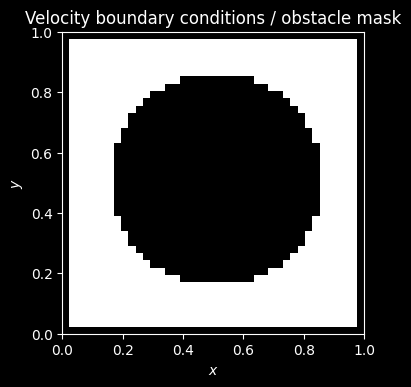

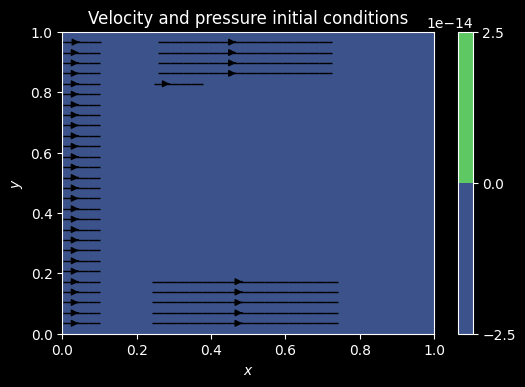

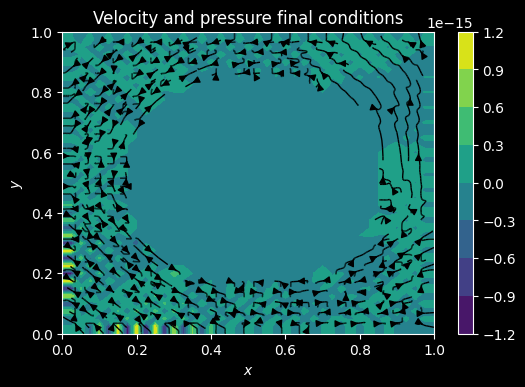

In [15]:

fluid = FluidSimulation(1,1,1,1)
fluid.init_obstacle_mask()
u,v,p,t = fluid.simulate(1000)
fluid.draw_plot(u, v, p)

# Heat transfer in a fluid
# https://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11
# Heat transfer in a fluid equation D2T/Dt2 = kappa * D2T/Dx2 + Q
# 

